###### Wavedrom Code Generator

In [1061]:
"""
Args:
Returns:
Attributes:          
Raises:
"""

'\nArgs:\nReturns:\nAttributes:          \nRaises:\n'

In [1062]:
import json;
import cv2;
import numpy as np;
from IPython.display import display;
from PIL import Image;

import matplotlib.pyplot as plt;

import pytesseract;

import skimage;

In [1063]:
simple_wavedrom_image = "min_sample.png";

In [1064]:
class WavedromCodeGenerator:
    """
    This class generates json code for wavedrom from a given image of wavedrom image.

    Args:

    Returns:

    Attributes:
        
    Raises:

    """
    def __init__( self ):
        """
        Args:

        Returns:

        Attributes:
            
        Raises:

        """
        self.raw_image = simple_wavedrom_image;
        self.names = self._extract_names();
        self.num_signals = len( self.names );
        self.image_matrix = self._preprocess_image();
        self.cropped_signals = self._crop_image_matrix( self.image_matrix );

    
    def _display_image( self, window_name = "Image" ):
        """
        Args:

        Returns:

        Attributes:
            
        Raises:

        """
        display( Image.open( self.raw_image ) );

    def _preprocess_image( self ):
        """
        Args:

        Returns:

        Attributes:
            
        Raises:

        """
        image = cv2.imread( self.raw_image, cv2.IMREAD_GRAYSCALE );
        _, image = cv2.threshold( image, 127, 255, cv2.THRESH_BINARY_INV );
        return image;

    def _plot_image( self, image_matrix ):
        """
        Args:

        Returns:

        Attributes:
            
        Raises:

        """
        if type( image_matrix ) == dict:
            for key in image_matrix.keys():
                plt.figure( figsize = ( 10, 10 ) );
                plt.title( key );
                plt.imshow( image_matrix[key], cmap = "gray" );
                plt.show();
        else:
            for i in range( self.num_signals ):
                plt.figure( figsize = ( 10, 10 ) );

                plt.title( self.names[i] );
                plt.imshow( image_matrix, cmap = "gray" );
                plt.show();

        #plt.imshow( image_matrix, cmap = "gray" );
        #plt.show();

    def _extract_names( self ):
        """
        Args:

        Returns:

        Attributes:
            
        Raises:

        """
        # extract the names of th signals. Names will be in english alphabets.
        data = pytesseract.image_to_string( self.raw_image, lang='eng', config='--psm 6' );

        data_list = list( data );

        # join the letters to form the names to a list
        names = [];
        name = "";
        for i in range( len( data_list ) ):
            if data_list[i].isalpha():
                name += data_list[i];
            else:
                if name:
                    names.append( name );
                    name = "";

        # set the number of signals
        return names;

    def _crop_image_matrix( self, image_matrix ):
        """
        Args:

        Returns:

        Attributes:
            
        Raises:

        """
        cropped_signals = {};
        start = 0;
        # crop the image to get the signals
        for i in range( self.num_signals ):
            div = int( 100/( self.num_signals + 1 ) * (i+1) );
            cropped_image = image_matrix[ start:div, 51: ];
            cropped_signals[ self.names[i] ] = cropped_image;
            start = div;
        return cropped_signals;

    def _extract_signal_data( self ):
        """
        Args:

        Returns:

        Attributes:
            
        Raises:

        """
        # line detectin to detect horizontal lines
        # hough transform to detect the lines
        # each period is 25 pixels so each high or low is 25 pixels

        for name in self.names:
            edges = cv2.Canny( self.cropped_signals[name], 150, 200 );
            cdst = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
            lines = cv2.HoughLines( edges, 1, np.pi / 180, 150, None, 0, 0 );

            print( lines.shape );
            print( lines[0][0][1] );

            # draw the lines
            for line in lines:
                rho, theta = line[0];
                a = np.cos( theta );
                b = np.sin( theta );
                x0 = a * rho;
                y0 = b * rho;
                x1 = int( x0 + 1000 * ( -b ) );
                y1 = int( y0 + 1000 * ( a ) );
                x2 = int( x0 - 1000 * ( -b ) );
                y2 = int( y0 - 1000 * ( a ) );

                cv2.line( cdst, ( x1, y1 ), ( x2, y2 ), ( 0, 0, 255 ), 1 );
            
        self._plot_image( cdst );

In [1065]:
obj = WavedromCodeGenerator();
image = obj._display_image( simple_wavedrom_image );

In [1066]:
print( obj.names );

['pclk']


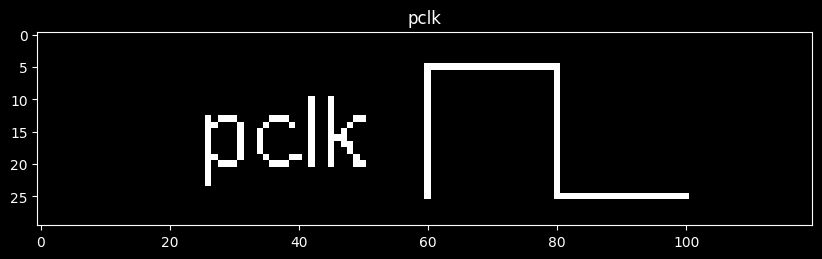

In [1067]:
plot_image = obj._plot_image( obj.image_matrix );

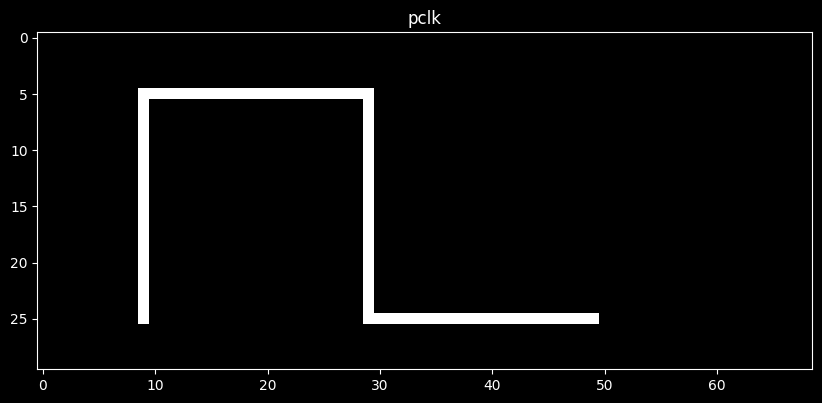

In [1068]:
plot_image = obj._plot_image( obj.cropped_signals );

In [1081]:
#print( obj.cropped_signals )
for name in obj.names:
    signal = obj.cropped_signals[name];
    #obj._plot_image( signal );

#print( signal.shape );
signal_copy = signal.copy();
cdst = cv2.cvtColor( signal_copy, cv2.COLOR_GRAY2BGR )

half_life = [];
counter = 0;

for i in range( cdst.shape[0] ):
    for j in range( cdst.shape[1] ):
        # if pixel is white
        if signal[i][j] == 255 and signal[i][j-1] == 0 and signal[i][j+1] == 0:

            # determine if rising or falling edge by checking previous and next pixel
            if signal[i-1][j] == 255 and signal[i+1][j] == 255:
                # falling edge
                if counter < 2:
                    half_life.append( j );
                    counter += 1;

#obj._plot_image( cdst );

# half period is difference between two elements in half_period
print( "Half-life:", half_life );
hp = half_life[1] - half_life[0];
period = hp * 2;
print( "Period:", period );

Half-life: [9, 29]
Period: 40


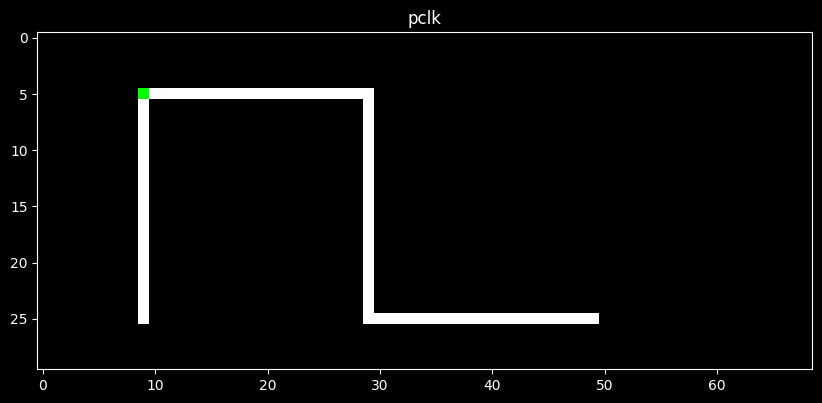

In [1088]:
for name in obj.names:
    signal = obj.cropped_signals[name];

signal_copy = signal.copy();
cdst = cv2.cvtColor( signal_copy, cv2.COLOR_GRAY2BGR )

for i in range( cdst.shape[0] ):
    for j in range( cdst.shape[1] ):
        # get all the corner pixels that are white
        if signal[i][j] == 255 and signal[i-1][j] == 0 and signal[i][j-1] == 0:
            #cdst[i][j] = [ 0, 255, 0 ];
            # check if high signal or low signal by check the pixel in the previous column and the next column
            if signal[i][j-1] == 0 and signal[i][j+1] == 255:
                print( "High signal" );



        #if signal[i][j] == 255 and signal[i-1][j] == 0 and signal[i][j+1] == 0:
            #cdst[i][j] = [ 0, 255, 0 ];

        #if signal[i][j] == 255 and signal[i+1][j] == 0 and signal[i][j-1] == 0:
            #cdst[i][j] = [ 0, 255, 0 ];

        #if signal[i][j] == 255 and signal[i+1][j] == 0 and signal[i][j+1] == 0:
            #cdst[i][j] = [ 0, 255, 0 ];

obj._plot_image( cdst );

In [1070]:
#obj._extract_signal_data();

In [1071]:
#for name in obj.names:
    #edges = cv2.Canny( obj.cropped_signals[name], 150, 200 );
    #cdst = cv2.cvtColor( edges, cv2.COLOR_GRAY2BGR )
    #lines = cv2.HoughLines( edges, 1, np.pi / 180, 150, None, 0, 0 );

    #print( edges[20] )

    #print( lines.shape );
    # keep the max and min in lines
    #print( lines.max( axis=0 ) );
    #print( lines.min( axis=0 ) );

    #high = lines.max( axis=0 );
    #low = lines.min( axis=0 );

    # check when the background is black 
    #print( edges.shape );

    # keep the high and low from the lines and remove the others
    #lines = np.array( [ high, low ] );

    #print( lines )

    # draw the lines
    """
    for line in lines:
        rho, theta = line[0];
        a = np.cos( theta );
        b = np.sin( theta );
        x0 = a * rho;
        y0 = b * rho;
        x1 = int( x0 + 1000 * ( -b ) );
        y1 = int( y0 + 1000 * ( a ) );
        x2 = int( x0 - 1000 * ( -b ) );
        y2 = int( y0 - 1000 * ( a ) );

        cv2.line( cdst, ( x1, y1 ), ( x2, y2 ), ( 0, 0, 255 ), 1 );
    """

#obj._plot_image( edges );
#print( edges.shape )
# label the pixel in edges
#for i in range( len( edges ) ):
    #for j in range( len( edges[i] ) ):
        
        # find the first pixel that is 255 and the last pixel that is 255
        #if edges[i][j] == 255:
            #min_pixel = j;
            #break;
            
#obj._plot_image( cdst );

IndentationError: unexpected indent (1789184515.py, line 25)